# Data preparation

- TODO: visualisation of Train Loss and Validate Loss => done
- TODO: table, maybe?

## Define and read files needed from datasets

In [76]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Countries lookup table
lookup_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")
# yield and production data
yield_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Yield_and_Production_data.csv")
# land cover data
land_cover_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Land_Cover_Percent_data.csv")
# define files to merge
climate_files = {
    "rain": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Rainf_tavg_data.csv",
    "snow": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Snowf_tavg_data.csv",
    "esoil": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/ESoil_tavg_data.csv",
    "soilmoisture_0_10": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi0_10cm_inst_data.csv",
    "soilmoisture_10_40": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi10_40cm_inst_data.csv",
    "soilmoisture_40_100": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi40_100cm_inst_data.csv",
    "soilmoisture_100_200": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilMoi100_200cm_inst_data.csv",
    "soiltemp_0_10": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP0_10cm_inst_data.csv",
    "soiltemp_10_40": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP10_40cm_inst_data.csv",
    "soiltemp_40_100": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP40_100cm_inst_data.csv",
    "soiltemp_100_200": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/SoilTMP100_200cm_inst_data.csv",
    "tveg": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/TVeg_tavg_data.csv",
    "tws": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/TWS_inst_data.csv",
    "canopint": "/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/CanopInt_inst_data.csv"  # Newly added dataset
}

## Spatial join and merge datasets

In [77]:
# Helper Function: process and average by country-year
def process_monthly_climate(filepath, variable_prefix, lookup_gdf):
    df = pd.read_csv(filepath)
    # Convert lat/lon into Shapely Points
    df['geometry'] = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    # Make GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')
    # Reproject to metric system for distance calculation
    gdf_proj = gdf.to_crs("EPSG:3857")
    lookup_proj = lookup_gdf.to_crs("EPSG:3857")
    # Spatial join to match each climate point to its nearest country lookup point
    joined = gpd.sjoin_nearest(gdf_proj, lookup_proj, how='left', distance_col='distance')
    # Drop geometry and return to original lat/lon projection
    joined = joined.to_crs("EPSG:4326").drop(columns='geometry')
    # Identify monthly columns (e.g. month_1 to month_12)
    month_cols = [col for col in df.columns if 'month' in col.lower()]
    # Rename them to include the variable prefix (e.g. rain_1, rain_2, ...)
    new_col_map = {col: f"{variable_prefix}_{i+1}" for i, col in enumerate(month_cols)}
    joined = joined.rename(columns=new_col_map)
    # Group by country + year and take the mean across all nearby points
    monthly_avg = joined.groupby(['country', 'year'])[[*new_col_map.values()]].mean().reset_index()
    return monthly_avg

lookup_df['geometry'] = [Point(xy) for xy in zip(lookup_df['longitude'], lookup_df['latitude'])]
lookup_gdf = gpd.GeoDataFrame(lookup_df, geometry='geometry', crs='EPSG:4326')
# lowercase column names
yield_df.columns = [c.strip().lower() for c in yield_df.columns]
# filter to only 'Yield' rows
yield_df = yield_df[yield_df["element"] == "Yield"]
# rename 'value' to 'yield'
if "yield" not in yield_df.columns and "value" in yield_df.columns:
    yield_df = yield_df.rename(columns={"value": "yield"})

# Process and merge all climate datasets
merged_climate = None
for prefix, path in climate_files.items():
    climate_df = process_monthly_climate(path, prefix, lookup_gdf)
    if merged_climate is None:
        merged_climate = climate_df
    else:
        # Outer join to accumulate all monthly features
        merged_climate = pd.merge(merged_climate, climate_df, on=["country", "year"], how="outer")

land_cover_df['geometry'] = [Point(xy) for xy in zip(land_cover_df['longitude'], land_cover_df['latitude'])]
land_cover_gdf = gpd.GeoDataFrame(land_cover_df, geometry='geometry', crs='EPSG:4326')
# Join each land cover point to nearest country point
land_cov_joined = gpd.sjoin_nearest(land_cover_gdf.to_crs("EPSG:3857"), lookup_gdf.to_crs("EPSG:3857"), how='left')
land_cov_joined = land_cov_joined.to_crs("EPSG:4326").drop(columns='geometry')
# Rename land cover class columns to standardized names
land_class_cols = [col for col in land_cover_df.columns if "class_" in col.lower()]
land_cov_col_map = {col: f"mean_cov_{col.split('_')[-1]}" for col in land_class_cols}
land_cov_joined = land_cov_joined.rename(columns=land_cov_col_map)
# Aggregate land cover by country (mean percent per class)
land_cov_summary = land_cov_joined.groupby("country")[list(land_cov_col_map.values())].mean().reset_index()

# Merge with climate on country + year
climate_with_land = pd.merge(merged_climate, land_cov_summary, on="country", how="left")

# Merge with yield data 
final_df = pd.merge(yield_df, climate_with_land, on=["country", "year"], how="inner")

# Organize column order
def ordered_columns(final_df):
    rain_cols = [f"rain_{i}" for i in range(1, 13)]
    snow_cols = [f"snow_{i}" for i in range(1, 13)]
    esoil_cols = [f"esoil_{i}" for i in range(1, 13)]
    soilm_cols, soilt_cols = [], []
    for layer in ["0_10", "10_40", "40_100", "100_200"]:
        soilm_cols += [f"soilmoisture_{layer}_{i}" for i in range(1, 13)]
        soilt_cols += [f"soiltemp_{layer}_{i}" for i in range(1, 13)]

    tveg_cols = [f"tveg_{i}" for i in range(1, 13)]
    tws_cols = [f"tws_{i}" for i in range(1, 13)]
    canopint_cols = [f"canopint_{i}" for i in range(1, 13)]
    landcov_cols = [f"mean_cov_{i}" for i in range(1, 18)]

    base_cols = ["country", "item", "year"]
    # Combine all expected features (filter only those that exist in the final DataFrame)
    all_features = landcov_cols + rain_cols + snow_cols + esoil_cols + soilm_cols + soilt_cols + tveg_cols + tws_cols + canopint_cols
    all_features = [col for col in all_features if col in final_df.columns]

    return base_cols + all_features + ["yield"]

final_df = final_df[ordered_columns(final_df)]

# Save final output
final_df.to_csv("Core_Dataset.csv", index=False)
print("Core dataset saved as Core_Dataset.csv")

Core dataset saved as Core_Dataset.csv


# Data preprocessing

## Data shaping

In [105]:
# Load data
df = pd.read_csv("Core_Dataset.csv")

# Move 'year' to the front
cols = df.columns.tolist()
if 'year' in cols:
    cols.insert(0, cols.pop(cols.index('year')))
df = df[cols]

# Display structure
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (67963, 189)
Columns: ['year', 'country', 'item', 'mean_cov_1', 'mean_cov_2', 'mean_cov_3', 'mean_cov_4', 'mean_cov_5', 'mean_cov_6', 'mean_cov_7', 'mean_cov_8', 'mean_cov_9', 'mean_cov_10', 'mean_cov_11', 'mean_cov_12', 'mean_cov_13', 'mean_cov_14', 'mean_cov_15', 'mean_cov_16', 'mean_cov_17', 'rain_1', 'rain_2', 'rain_3', 'rain_4', 'rain_5', 'rain_6', 'rain_7', 'rain_8', 'rain_9', 'rain_10', 'rain_11', 'rain_12', 'snow_1', 'snow_2', 'snow_3', 'snow_4', 'snow_5', 'snow_6', 'snow_7', 'snow_8', 'snow_9', 'snow_10', 'snow_11', 'snow_12', 'esoil_1', 'esoil_2', 'esoil_3', 'esoil_4', 'esoil_5', 'esoil_6', 'esoil_7', 'esoil_8', 'esoil_9', 'esoil_10', 'esoil_11', 'esoil_12', 'soilmoisture_0_10_1', 'soilmoisture_0_10_2', 'soilmoisture_0_10_3', 'soilmoisture_0_10_4', 'soilmoisture_0_10_5', 'soilmoisture_0_10_6', 'soilmoisture_0_10_7', 'soilmoisture_0_10_8', 'soilmoisture_0_10_9', 'soilmoisture_0_10_10', 'soilmoisture_0_10_11', 'soilmoisture_0_10_12', 'soilmoisture_10_40_1', 'soilmoi

In [106]:
# Convert year to integer format (e.g. 2010, 2011, ...)
df['year_raw'] = df['year'].astype(int)  # backup for clean export
# Optional sanity check
print("Years in dataset:", sorted(df['year'].unique()))

Years in dataset: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]


In [107]:
# Shift Yield by -1 per country/item
df['target'] = df.groupby(['country', 'item'])['yield'].shift(-1)

# Drop rows without target
df = df.dropna(subset=['target']).copy()

In [108]:
from sklearn.preprocessing import LabelEncoder

# Encode 'country' and 'item'
df['country_enc'] = LabelEncoder().fit_transform(df['country'])

df = pd.get_dummies(df, columns=['item'], prefix='item')


country_encoder = LabelEncoder()
df['country_id'] = country_encoder.fit_transform(df['country'])
num_countries = df['country_id'].nunique()

year_encoder = LabelEncoder()
df['year_id'] = year_encoder.fit_transform(df['year_raw'])  # keep 'year_raw' as integer
num_years = df['year_id'].nunique()

## Normalisation

In [109]:
from sklearn.preprocessing import MinMaxScaler

# Features to exclude
exclude = ['Yield', 'target', 'country','item','year_raw', 'country_id', 'year', 'year_id']
one_hot_cols = [col for col in df.columns if col.startswith('item_')]
feature_cols = [col for col in df.columns if col not in exclude and col not in one_hot_cols]
feature_cols += one_hot_cols  # include one-hot columns explicitly

scaler = MinMaxScaler()
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')  # force numeric
df[feature_cols] = scaler.fit_transform(df[feature_cols])
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())  # fill NaNs

# add one-hot columns after fit transform because we don't want to scale one-hot columns (they are already 0/1)

# Create separate scaler for target
target_scaler = MinMaxScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['target']])

# Fill any remaining NaNs after scaling
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())

print(df[feature_cols].head())
results = df[feature_cols].copy()
results.to_csv("features.csv", index=False)


/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_4256/2489308846.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target_scaled'] = target_scaler.fit_transform(df[['target']])


   mean_cov_1  mean_cov_2  mean_cov_3  mean_cov_4  mean_cov_5  mean_cov_6  \
0         1.0         0.0         0.0         0.0         0.0         0.0   
1         1.0         0.0         0.0         0.0         0.0         0.0   
2         1.0         0.0         0.0         0.0         0.0         0.0   
3         1.0         0.0         0.0         0.0         0.0         0.0   
4         1.0         0.0         0.0         0.0         0.0         0.0   

   mean_cov_7  mean_cov_8  mean_cov_9  mean_cov_10  ...  \
0         0.0         0.0         0.0          0.0  ...   
1         0.0         0.0         0.0          0.0  ...   
2         0.0         0.0         0.0          0.0  ...   
3         0.0         0.0         0.0          0.0  ...   
4         0.0         0.0         0.0          0.0  ...   

   item_Tallowtree seeds  item_Tangerines, mandarins, clementines  \
0                    0.0                                      0.0   
1                    0.0                    

## Splitting

In [110]:
from sklearn.model_selection import train_test_split

# # Split the data
# train_df = df[df['year'] <= 2020].copy().reset_index(drop=True)
# remaining_df = df[df['year'] > 2020].copy().reset_index(drop=True)

# # Split the remaining data into validation and test sets (50:50 split)
# val_df, test_df = train_test_split(remaining_df, test_size=0.5, random_state=42)

# # Reset indices
# val_df = val_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

# print(f"Train: years <= 2020, Validation/Test: years > 2020")
# print("Train size:", len(train_df))
# print("Validation size:", len(val_df))
# print("Test size:", len(test_df))

# from sklearn.model_selection import train_test_split

#Split the full cleaned DataFrame (after encoding + scaling + shift)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Split test_df into validation and test sets (50:50 split)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 49998
Validation size: 6250
Test size: 6250


In [111]:
# Detect and drop constant features
zero_var_cols = train_df[feature_cols].loc[:, train_df[feature_cols].std() == 0].columns.tolist()
train_df = train_df.drop(columns=zero_var_cols)
val_df = val_df.drop(columns=zero_var_cols)
test_df = test_df.drop(columns=zero_var_cols)
feature_cols = [col for col in feature_cols if col not in zero_var_cols]

In [112]:
import torch

# X_train = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
# # y_train = torch.tensor(train_df['target'].values, dtype=torch.float32).view(-1, 1)
# y_train = torch.tensor(train_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

# X_test = torch.tensor(test_df[feature_cols].values, dtype=torch.float32)
# # y_test = torch.tensor(test_df['target'].values, dtype=torch.float32).view(-1, 1)
# y_test = torch.tensor(test_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

# Rescale predictions back to actual yield units
X_train_num = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
X_train_country = torch.tensor(train_df['country_id'].values, dtype=torch.long)
y_train = torch.tensor(train_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)
# Convert validation data to tensors
X_val_num = torch.tensor(val_df[feature_cols].values, dtype=torch.float32)
X_val_country = torch.tensor(val_df['country_id'].values, dtype=torch.long)
y_val = torch.tensor(val_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

X_test_num = torch.tensor(test_df[feature_cols].values, dtype=torch.float32)
X_test_country = torch.tensor(test_df['country_id'].values, dtype=torch.long)
y_test = torch.tensor(test_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

# Convert to tensors
X_train_year = torch.tensor(train_df['year_id'].values, dtype=torch.long)
X_test_year = torch.tensor(test_df['year_id'].values, dtype=torch.long)
X_val_year = torch.tensor(val_df['year_id'].values, dtype=torch.long)

## ML Model and Training

In [88]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(
    TensorDataset(X_train_num, X_train_country, X_train_year, y_train),
    batch_size=32,
    shuffle=True
)

class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_countries, num_years, emb_dim_country=8, emb_dim_year=4):
        super().__init__()
        self.country_emb = nn.Embedding(num_countries, emb_dim_country)
        self.year_emb = nn.Embedding(num_years, emb_dim_year)

        total_input_dim = input_dim + emb_dim_country + emb_dim_year

        self.model = nn.Sequential(
            # nn.Linear(total_input_dim, 256),
            # nn.BatchNorm1d(256),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(256, 128),
            # nn.BatchNorm1d(128),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(128, 64),
            # nn.BatchNorm1d(64),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(64, 1)
            # nn.Sigmoid()  # Ensures output is between 0 and 1
            nn.Linear(total_input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Clamp output
        )

    def forward(self, x_num, x_country, x_year):
        c_vec = self.country_emb(x_country)
        y_vec = self.year_emb(x_year)
        x = torch.cat([x_num, c_vec, y_vec], dim=1)
        return self.model(x)
    

model = MLPWithEmbeddings(
    input_dim=X_train_num.shape[1],
    num_countries=num_countries,
    num_years=num_years,
    emb_dim_country=8,
    emb_dim_year=4
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# loss_fn = nn.SmoothL1Loss()
loss_fn = nn.MSELoss()

# for epoch in range(50):
#     model.train()
#     total_loss = 0.0
#     for xb_num, xb_country, xb_year, yb in train_loader:
#         pred = model(xb_num, xb_country, xb_year)
#         loss = loss_fn(pred, yb)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * xb_num.size(0)

#     avg_loss = total_loss / len(train_loader.dataset)
#     print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

# --- Early stopping setup ---
patience = 5
best_loss = float('inf')
counter = 0

# --- Training ---
for epoch in range(100):
    model.train()
    total_loss = 0.0
    for xb_num, xb_country, xb_year, yb in train_loader:
        pred = model(xb_num, xb_country, xb_year)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb_num.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}")

    # --- Early stopping logic ---
    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
        best_model_state = model.state_dict()  # Save best model so far
    else:
        counter += 1
        print(f"  🔁 No improvement for {counter} epoch(s).")

        if counter >= patience:
            print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}.")
            break

# --- Restore best model ---
model.load_state_dict(best_model_state)
print("✅ Best model restored.")
    

Epoch 1, Avg Loss: 0.0055


KeyboardInterrupt: 

In [138]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error


train_loader = DataLoader(
    TensorDataset(X_train_num, X_train_country, X_train_year, y_train),
    batch_size=32,
    shuffle=True
)

class MLPWithEmbeddings(nn.Module):
    def __init__(self, input_dim, num_countries, num_years, emb_dim_country=8, emb_dim_year=4):
        super().__init__()
        self.country_emb = nn.Embedding(num_countries, emb_dim_country)
        self.year_emb = nn.Embedding(num_years, emb_dim_year)

        total_input_dim = input_dim + emb_dim_country + emb_dim_year

        self.model = nn.Sequential(
            # nn.Linear(total_input_dim, 256),
            # nn.BatchNorm1d(256),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(256, 128),
            # nn.BatchNorm1d(128),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(128, 64),
            # nn.BatchNorm1d(64),
            # nn.ReLU(),
            # nn.Dropout(0.2),
            # nn.Linear(64, 1)
            # nn.Sigmoid()  # Ensures output is between 0 and 1
            nn.Linear(total_input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Clamp output
        )

    def forward(self, x_num, x_country, x_year):
        c_vec = self.country_emb(x_country)
        y_vec = self.year_emb(x_year)
        x = torch.cat([x_num, c_vec, y_vec], dim=1)
        return self.model(x)
    

model = MLPWithEmbeddings(
    input_dim=X_train_num.shape[1],
    num_countries=num_countries,
    num_years=num_years,
    emb_dim_country=8,
    emb_dim_year=4
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
# loss_fn = nn.SmoothL1Loss()
loss_fn = nn.MSELoss()
# --- Training with Validation ---
train_losses, train_maes, val_losses, val_maes = [], [], [], []

# --- Early stopping setup ---
patience = 5
best_loss = float('inf')
counter = 0

for epoch in range(100):
    # Training phase
    model.train()
    total_train_loss, total_train_mae = 0.0, 0.0
    for xb_num, xb_country, xb_year, yb in train_loader:
        pred = model(xb_num, xb_country, xb_year)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb_num.size(0)
        total_train_mae += mean_absolute_error(yb.detach().numpy(), pred.detach().numpy()) * xb_num.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)
    avg_train_mae = total_train_mae / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_maes.append(avg_train_mae)

    # Validation phase
    model.eval()
    total_val_loss, total_val_mae = 0.0, 0.0
    with torch.no_grad():
        for xb_num, xb_country, xb_year, yb in DataLoader(
            TensorDataset(X_val_num, X_val_country, X_val_year, y_val),
            batch_size=32,
            shuffle=False
        ):
            pred = model(xb_num, xb_country, xb_year)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item() * xb_num.size(0)
            total_val_mae += mean_absolute_error(yb.numpy(), pred.numpy()) * xb_num.size(0)

    avg_val_loss = total_val_loss / len(y_val)
    avg_val_mae = total_val_mae / len(y_val)
    val_losses.append(avg_val_loss)
    val_maes.append(avg_val_mae)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val MAE: {avg_val_mae:.4f}")

    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        best_model_state = model.state_dict()  # Save best model so far
    else:
        counter += 1
        print(f"  🔁 No improvement for {counter} epoch(s).")

        if counter >= patience:
            print(f"\n⏹️ Early stopping triggered at epoch {epoch+1}.")
            break

# --- Restore best model ---
model.load_state_dict(best_model_state)
print("✅ Best model restored.")

Epoch 1, Train Loss: 0.0072, Train MAE: 0.0458, Val Loss: 0.0004, Val MAE: 0.0137
Epoch 2, Train Loss: 0.0006, Train MAE: 0.0144, Val Loss: 0.0003, Val MAE: 0.0102
Epoch 3, Train Loss: 0.0005, Train MAE: 0.0125, Val Loss: 0.0002, Val MAE: 0.0081
Epoch 4, Train Loss: 0.0004, Train MAE: 0.0115, Val Loss: 0.0002, Val MAE: 0.0079
Epoch 5, Train Loss: 0.0004, Train MAE: 0.0107, Val Loss: 0.0001, Val MAE: 0.0067
Epoch 6, Train Loss: 0.0003, Train MAE: 0.0100, Val Loss: 0.0001, Val MAE: 0.0069
Epoch 7, Train Loss: 0.0003, Train MAE: 0.0095, Val Loss: 0.0001, Val MAE: 0.0070
  🔁 No improvement for 1 epoch(s).
Epoch 8, Train Loss: 0.0002, Train MAE: 0.0090, Val Loss: 0.0001, Val MAE: 0.0057
Epoch 9, Train Loss: 0.0002, Train MAE: 0.0086, Val Loss: 0.0002, Val MAE: 0.0066
  🔁 No improvement for 1 epoch(s).
Epoch 10, Train Loss: 0.0002, Train MAE: 0.0084, Val Loss: 0.0001, Val MAE: 0.0065
  🔁 No improvement for 2 epoch(s).
Epoch 11, Train Loss: 0.0002, Train MAE: 0.0082, Val Loss: 0.0001, Val MAE

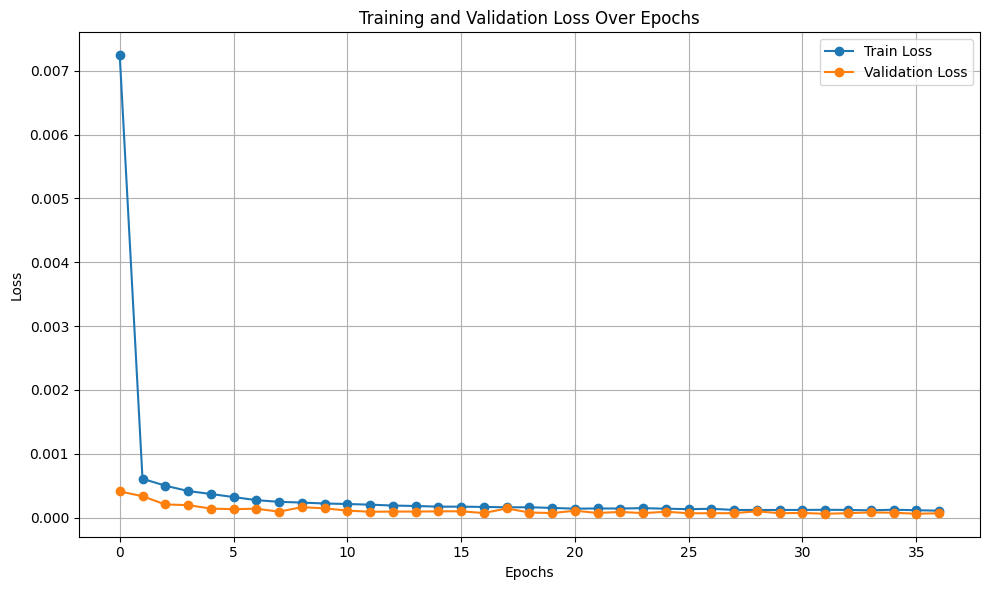

In [139]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing

In [140]:
from sklearn.metrics import mean_absolute_error

# Predict
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_num, X_test_country, X_test_year).numpy().flatten()  # predicted (scaled)
    y_true_test = y_test.numpy().flatten()                                          # true (scaled)

# Inverse transform to original yield scale
y_pred_rescaled = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_true_rescaled = target_scaler.inverse_transform(y_true_test.reshape(-1, 1)).flatten()

# Calculate MAE
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
print(f"\n🧪 Test MAE: {mae:.2f}")


🧪 Test MAE: 1731.39


In [141]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate Test Loss and Test MAE

# Ensure the model is in evaluation mode
model.eval()

# Predict on the test set
with torch.no_grad():
    y_pred_test = model(X_test_num, X_test_country, X_test_year).numpy().flatten()  # predicted (scaled)
    y_true_test = y_test.numpy().flatten()                                          # true (scaled)

# Calculate Test Loss (MSE)
test_loss = mean_squared_error(y_true_test, y_pred_test)

# Calculate Test MAE
test_mae = mean_absolute_error(y_true_test, y_pred_test)

print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss (MSE): 0.0001
Test MAE: 0.0041


In [142]:
print("🔍 Prediction range:", y_pred_test.min(), "to", y_pred_test.max())
print("✅ True yield range:", y_true_test.min(), "to", y_true_test.max())

🔍 Prediction range: 0.0006263941 to 0.8432334
✅ True yield range: 0.0 to 0.9194379


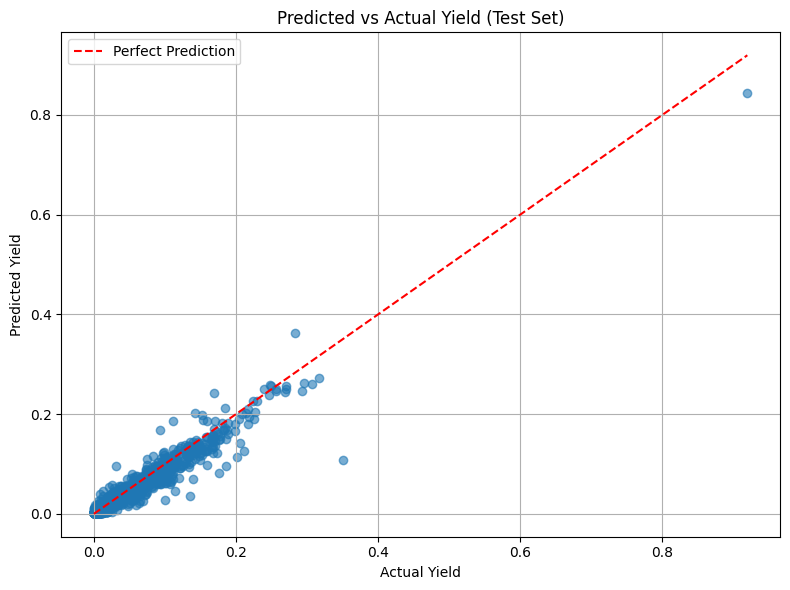

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true_test, y_pred_test, alpha=0.6)
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [144]:
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)

In [145]:
# 1. Recover the item name from one-hot columns
item_cols = [col for col in test_df.columns if col.startswith('item_')]
test_df['item'] = test_df[item_cols].idxmax(axis=1).str.replace('item_', '')

# 2. Restore predictions and ground truth
test_df['yield_true'] = y_true_rescaled
test_df['yield_pred'] = y_pred_rescaled

# 3. Select clean columns for display
results_table = test_df[['year_raw', 'country', 'item', 'yield_true', 'yield_pred']]
results_table = results_table.rename(columns={'year_raw': 'year'})

# 4. Preview the output
print(results_table.head(20))

    year                             country  \
0   2010                            Pakistan   
1   2018                             Bahrain   
2   2017                               Niger   
3   2011                         Timor-Leste   
4   2013                             Ecuador   
5   2020                              Zambia   
6   2018                            Slovakia   
7   2017    Lao People's Democratic Republic   
8   2021                              Serbia   
9   2018                            Colombia   
10  2019                             Algeria   
11  2015                             Lesotho   
12  2016                             Ukraine   
13  2016           China, Taiwan Province of   
14  2017                           Palestine   
15  2020                            Thailand   
16  2010            United States of America   
17  2015                            Portugal   
18  2016  Venezuela (Bolivarian Republic of)   
19  2010                              Fr

In [146]:
results_table.to_csv("yield_predictions.csv", index=False)
print("✅ Results saved to 'yield_predictions.csv'")

✅ Results saved to 'yield_predictions.csv'


In [147]:
test_df['yield_true'] = y_true_rescaled
test_df['yield_pred'] = y_pred_rescaled

from sklearn.metrics import mean_absolute_error

year_mae = test_df.groupby('year_raw').apply(
    lambda x: mean_absolute_error(x['yield_true'], x['yield_pred'])
).reset_index(name='mae')

/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_4256/1397942013.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_mae = test_df.groupby('year_raw').apply(


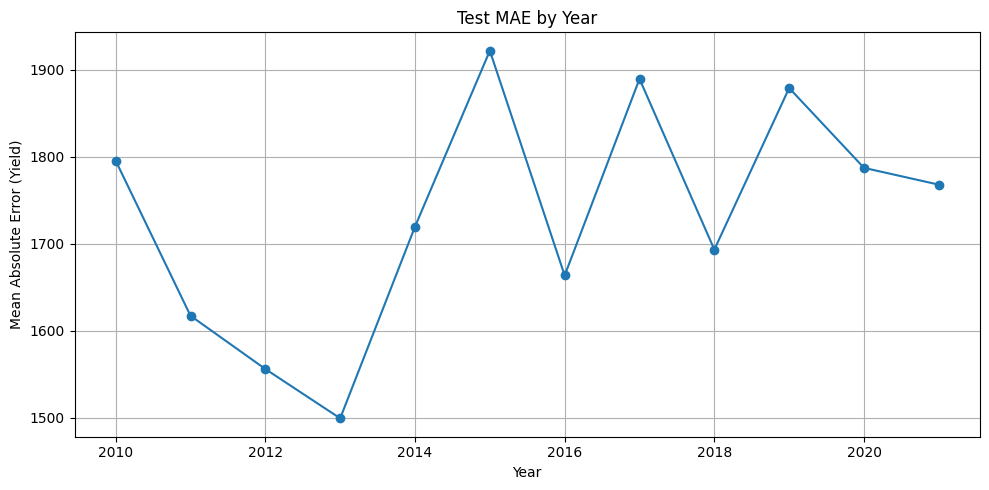

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(year_mae['year_raw'], year_mae['mae'], marker='o', linestyle='-')
plt.title("Test MAE by Year")
plt.xlabel("Year")
plt.ylabel("Mean Absolute Error (Yield)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [149]:
year_counts = test_df['year_raw'].value_counts().sort_index()
year_mae['count'] = year_counts.values
print(year_mae)

    year_raw          mae  count
0       2010  1795.247192    534
1       2011  1617.196289    572
2       2012  1556.045898    530
3       2013  1499.408569    510
4       2014  1719.577148    509
5       2015  1921.575928    520
6       2016  1663.506836    491
7       2017  1889.220703    501
8       2018  1693.172363    528
9       2019  1878.725098    521
10      2020  1787.036011    500
11      2021  1767.760498    534
